In [1]:
import pandas as pd
import glob
import time
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

- 入力データが、寿命100未満か100以上かを二値分類(出力A)
- 寿命が100未満と100以上を別々に学習(出力B, C)
- 出力B, C をAで重みをつけて、スコアとする

In [2]:
df_train = pd.DataFrame()
train_features_path = ['../features/train__200__important_columns.pkl',
                       '../features/train__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/train__004__cumsum_per_FlightRegime.pkl',
                       '../features/train__005__count_FlightRegime.pkl'
                       ]
for file_path in train_features_path:
    print(file_path)
    df_tmp = pd.read_pickle(file_path)
    df_train = pd.concat([df_train, df_tmp], axis=1)

../features/train__200__important_columns.pkl
../features/train__201__rolling_mean_per_FlightRegime.pkl
../features/train__004__cumsum_per_FlightRegime.pkl
../features/train__005__count_FlightRegime.pkl


In [3]:
df_test = pd.DataFrame()
test_features_path = ['../features/test__200__important_columns.pkl',
                       '../features/test__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/test__004__cumsum_per_FlightRegime.pkl',
                       '../features/test__005__count_FlightRegime.pkl'
                       ]
for file_path in test_features_path:
    df_tmp = pd.read_pickle(file_path)
    df_test = pd.concat([df_test, df_tmp], axis=1)

In [4]:
target = pd.read_pickle('../features/target__000__raw_data.pkl')

In [5]:
Engine_list_sort_by_length = list(df_train.EngineID.value_counts().index)
folds_EngineID = []
folds_EngineID.append(Engine_list_sort_by_length[0::10])
folds_EngineID.append(Engine_list_sort_by_length[1::10])
folds_EngineID.append(Engine_list_sort_by_length[2::10])
folds_EngineID.append(Engine_list_sort_by_length[3::10])
folds_EngineID.append(Engine_list_sort_by_length[4::10])
folds_EngineID.append(Engine_list_sort_by_length[5::10])
folds_EngineID.append(Engine_list_sort_by_length[6::10])
folds_EngineID.append(Engine_list_sort_by_length[7::10])
folds_EngineID.append(Engine_list_sort_by_length[8::10])
folds_EngineID.append(Engine_list_sort_by_length[9::10])

In [6]:
test_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - 1
test_lastidx = list(test_lastidx)

In [7]:
train_idx = []
for i in range(10):
    print(i)
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - i
    train_idx.extend(list(train_lastidx))
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values + i
    train_idx.extend(list(train_lastidx))
train_idx = set(train_idx)

0
1
2
3
4
5
6
7
8
9


In [8]:
oof = df_train[['EngineID', 'EngineIndex', 'Flight Regime']]
oof = pd.concat([oof, target[['lifespan']]], axis=1)
oof['pre_start'] = np.nan
oof['pre_end'] = np.nan
oof['pre_border'] = np.nan
oof['pre_all'] = np.nan
oof = oof[oof['EngineIndex'].isin(test_lastidx)]

In [9]:
oof.head()

,EngineID,EngineIndex,Flight Regime,lifespan,pre_start,pre_end,pre_border,pre_all
20,Train_Engine_001,20,6,128,NaN,NaN,NaN,NaN
21,Train_Engine_001,21,6,127,NaN,NaN,NaN,NaN
22,Train_Engine_001,22,6,126,NaN,NaN,NaN,NaN
30,Train_Engine_001,30,2,118,NaN,NaN,NaN,NaN
42,Train_Engine_001,42,6,106,NaN,NaN,NaN,NaN


----------- lifespan が100以上 or 100未満を学習-----------  
100以上:0, 100未満:1

In [10]:
target_border = target[['lifespan', 'EngineID', 'EngineIndex', 'Flight Regime']].copy()
target_border['target_border'] = np.nan
target_border.loc[target_border['lifespan'] >= 100, 'target_border'] = 0
target_border.loc[target_border['lifespan'] < 100, 'target_border'] = 1
del target_border['lifespan']

In [11]:
features = [c for c in df_train.columns if c not in ['Flight Regime', 'EngineID', 'EngineIndex']]
categorical_feats = []

In [12]:
param_border = {'num_leaves': 200,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 17,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 133,
         "n_jobs":-1}
num_round = 1000
predictions = np.zeros(len(df_test))
start = time.time()
feature_importance_list = []

In [13]:
predictions = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train[df_train['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_border_fr = target_border[target_border['Flight Regime'] == fr][['target_border', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_border_fr[(~(target_border_fr['EngineID'].isin(val_ID))) &
                                               (target_border_fr['EngineIndex'].isin(train_idx))]['target_border'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_border_fr[(target_border_fr['EngineID'].isin(val_ID)) &
                                                      (target_border_fr['EngineIndex'].isin(test_lastidx))]['target_border'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param_border,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                         (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_border'] = val_pre
        
        predictions[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.949373
[200]	training's auc: 1	valid_1's auc: 0.948415
Early stopping, best iteration is:
[50]	training's auc: 0.999193	valid_1's auc: 0.953779
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.909397
[200]	training's auc: 1	valid_1's auc: 0.906467
Early stopping, best iteration is:
[76]	training's auc: 0.999999	valid_1's auc: 0.911892
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.930644
[200]	training's auc: 1	valid_1's auc: 0.93646
Early stopping, best iteration is:
[99]	training's auc: 1	valid_1's auc: 0.931018
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999999	valid_1's auc: 0.948794
[200]	training's auc: 1	valid_1's auc: 0.947876
[300]	training's auc: 1	valid_1's auc: 0.945408
Early stopping, best iteration is:
[104]	training's auc: 1	valid_1's auc: 0.950287
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.894284
[200]	training's auc: 1	valid_1's auc: 0.896039
Early stopping, best iteration is:
[38]	training's auc: 0.996388	valid_1's auc: 0.901415
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920497
[200]	training's auc: 1	valid_1's auc: 0.919947
Early stopping, best iteration is:
[48]	training's auc: 0.99906	valid_1's auc: 0.922559
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.927422
[200]	training's auc: 1	valid_1's auc: 0.926388
Early stopping, best iteration is:
[96]	training's auc: 1	valid_1's auc: 0.92633
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.91273
[200]	training's auc: 1	valid_1's auc: 0.913692
Early stopping, best iteration is:
[86]	training's auc: 1	valid_1's auc: 0.914353
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999999	valid_1's auc: 0.914318
[200]	training's auc: 1	valid_1's auc: 0.914573
[300]	training's auc: 1	valid_1's auc: 0.913194
Early stopping, best iteration is:
[120]	training's auc: 1	valid_1's auc: 0.915441
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.909977
[200]	training's auc: 1	valid_1's auc: 0.906677
Early stopping, best iteration is:
[46]	training's auc: 0.998661	valid_1's auc: 0.915979


 17%|██████████████                                                                      | 1/6 [01:35<07:59, 95.93s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.949241
[200]	training's auc: 1	valid_1's auc: 0.947542
Early stopping, best iteration is:
[62]	training's auc: 0.999943	valid_1's auc: 0.952888
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.953275
[200]	training's auc: 1	valid_1's auc: 0.952282
Early stopping, best iteration is:
[88]	training's auc: 1	valid_1's auc: 0.95114
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.895362
[200]	training's auc: 1	valid_1's auc: 0.89508
Early stopping, best iteration is:
[82]	training's auc: 1	valid_1's auc: 0.89463
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.892391
[200]	training's auc: 1	valid_1's auc: 0.892965
Early stopping, best iteration is:
[84]	training's auc: 1	valid_1's auc: 0.894583
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999928	valid_1's auc: 0.889885
[200]	training's auc: 0.999992	valid_1's auc: 0.887845
Early stopping, best iteration is:
[16]	training's auc: 0.985382	valid_1's auc: 0.90422
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.90016
[200]	training's auc: 1	valid_1's auc: 0.900837
Early stopping, best iteration is:
[59]	training's auc: 0.999853	valid_1's auc: 0.904035
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.909694
[200]	training's auc: 1	valid_1's auc: 0.907256
Early stopping, best iteration is:
[73]	training's auc: 0.999986	valid_1's auc: 0.915476
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.913635
[200]	training's auc: 1	valid_1's auc: 0.907036
Early stopping, best iteration is:
[85]	training's auc: 1	valid_1's auc: 0.91819
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.946572
[200]	training's auc: 1	valid_1's auc: 0.945059
Early stopping, best iteration is:
[82]	training's auc: 1	valid_1's auc: 0.9418
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.901507
[200]	training's auc: 1	valid_1's auc: 0.90579
Early stopping, best iteration is:
[94]	training's auc: 1	valid_1's auc: 0.901222


 33%|████████████████████████████                                                        | 2/6 [03:16<06:29, 97.26s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.939697
[200]	training's auc: 1	valid_1's auc: 0.943908
Early stopping, best iteration is:
[87]	training's auc: 1	valid_1's auc: 0.939023
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.924628
[200]	training's auc: 1	valid_1's auc: 0.92561
Early stopping, best iteration is:
[62]	training's auc: 0.999896	valid_1's auc: 0.932072
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999999	valid_1's auc: 0.895936
[200]	training's auc: 1	valid_1's auc: 0.8949
Early stopping, best iteration is:
[48]	training's auc: 0.999139	valid_1's auc: 0.905376
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.908866
[200]	training's auc: 1	valid_1's auc: 0.908128
Early stopping, best iteration is:
[46]	training's auc: 0.999023	valid_1's auc: 0.914875
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.895157
[200]	training's auc: 1	valid_1's auc: 0.891798
Early stopping, best iteration is:
[46]	training's auc: 0.99905	valid_1's auc: 0.905489
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.859365
[200]	training's auc: 1	valid_1's auc: 0.863155
Early stopping, best iteration is:
[17]	training's auc: 0.985351	valid_1's auc: 0.866332
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.878581
[200]	training's auc: 1	valid_1's auc: 0.87954
Early stopping, best iteration is:
[29]	training's auc: 0.993934	valid_1's auc: 0.897698
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.913487
[200]	training's auc: 1	valid_1's auc: 0.918743
Early stopping, best iteration is:
[40]	training's auc: 0.997785	valid_1's auc: 0.923683
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.927814
[200]	training's auc: 1	valid_1's auc: 0.924479
Early stopping, best iteration is:
[37]	training's auc: 0.997293	valid_1's auc: 0.93109
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.907814
[200]	training's auc: 1	valid_1's auc: 0.908764
Early stopping, best iteration is:
[30]	training's auc: 0.994571	valid_1's auc: 0.91514


 50%|██████████████████████████████████████████                                          | 3/6 [04:51<04:50, 96.73s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.931327
[200]	training's auc: 1	valid_1's auc: 0.930333
Early stopping, best iteration is:
[29]	training's auc: 0.992805	valid_1's auc: 0.938574
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.918035
[200]	training's auc: 1	valid_1's auc: 0.916247
Early stopping, best iteration is:
[85]	training's auc: 0.999999	valid_1's auc: 0.920683
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.907486
[200]	training's auc: 1	valid_1's auc: 0.909771
Early stopping, best iteration is:
[16]	training's auc: 0.984172	valid_1's auc: 0.913371
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.914152
[200]	training's auc: 1	valid_1's auc: 0.916837
Early stopping, best iteration is:
[83]	training's auc: 1	valid_1's auc: 0.91324
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.884401
[200]	training's auc: 1	valid_1's auc: 0.886817
Early stopping, best iteration is:
[13]	training's auc: 0.980926	valid_1's auc: 0.907169
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.86331
[200]	training's auc: 1	valid_1's auc: 0.867302
Early stopping, best iteration is:
[29]	training's auc: 0.992453	valid_1's auc: 0.870951
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.900223
[200]	training's auc: 1	valid_1's auc: 0.90269
Early stopping, best iteration is:
[37]	training's auc: 0.996687	valid_1's auc: 0.909443
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.893061
[200]	training's auc: 1	valid_1's auc: 0.893116
[300]	training's auc: 1	valid_1's auc: 0.894214
Early stopping, best iteration is:
[104]	training's auc: 1	valid_1's auc: 0.892512
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.936159
[200]	training's auc: 1	valid_1's auc: 0.933477
Early stopping, best iteration is:
[82]	training's auc: 1	valid_1's auc: 0.935984
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.928722
[200]	training's auc: 1	valid_1's auc: 0.934496
Early stopping, best iteration is:
[9]	training's auc: 0.976494	valid_1's auc: 0.940692


 67%|████████████████████████████████████████████████████████                            | 4/6 [06:30<03:14, 97.34s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.933815
[200]	training's auc: 1	valid_1's auc: 0.933639
Early stopping, best iteration is:
[51]	training's auc: 0.999407	valid_1's auc: 0.943681
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920487
[200]	training's auc: 1	valid_1's auc: 0.917719
Early stopping, best iteration is:
[93]	training's auc: 1	valid_1's auc: 0.920266
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999963	valid_1's auc: 0.924163
[200]	training's auc: 1	valid_1's auc: 0.923892
[300]	training's auc: 1	valid_1's auc: 0.920755
Early stopping, best iteration is:
[139]	training's auc: 0.999998	valid_1's auc: 0.924812
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.91572
[200]	training's auc: 1	valid_1's auc: 0.916536
Early stopping, best iteration is:
[67]	training's auc: 0.999969	valid_1's auc: 0.921781
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920135
[200]	training's auc: 1	valid_1's auc: 0.913823
Early stopping, best iteration is:
[34]	training's auc: 0.994963	valid_1's auc: 0.931446
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.902366
[200]	training's auc: 1	valid_1's auc: 0.904543
Early stopping, best iteration is:
[88]	training's auc: 1	valid_1's auc: 0.899541
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.860172
[200]	training's auc: 1	valid_1's auc: 0.858718
Early stopping, best iteration is:
[9]	training's auc: 0.973375	valid_1's auc: 0.890131
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999996	valid_1's auc: 0.920734
[200]	training's auc: 1	valid_1's auc: 0.92005
[300]	training's auc: 1	valid_1's auc: 0.923073
Early stopping, best iteration is:
[138]	training's auc: 1	valid_1's auc: 0.920963
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920481
[200]	training's auc: 1	valid_1's auc: 0.922772
Early stopping, best iteration is:
[47]	training's auc: 0.998963	valid_1's auc: 0.924786
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999959	valid_1's auc: 0.911765
[200]	training's auc: 1	valid_1's auc: 0.908396
Early stopping, best iteration is:
[38]	training's auc: 0.996889	valid_1's auc: 0.914228


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [08:11<01:38, 98.54s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.923627
[200]	training's auc: 1	valid_1's auc: 0.921611
Early stopping, best iteration is:
[66]	training's auc: 0.999994	valid_1's auc: 0.928062
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.906916
[200]	training's auc: 1	valid_1's auc: 0.90708
Early stopping, best iteration is:
[33]	training's auc: 0.997797	valid_1's auc: 0.916805
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.914782
[200]	training's auc: 1	valid_1's auc: 0.911189
Early stopping, best iteration is:
[81]	training's auc: 1	valid_1's auc: 0.918315
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.935676
[200]	training's auc: 1	valid_1's auc: 0.939025
Early stopping, best iteration is:
[38]	training's auc: 0.998832	valid_1's auc: 0.939516
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.91254
[200]	training's auc: 1	valid_1's auc: 0.912179
Early stopping, best iteration is:
[44]	training's auc: 0.999515	valid_1's auc: 0.917971
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.896444
[200]	training's auc: 1	valid_1's auc: 0.902634
Early stopping, best iteration is:
[92]	training's auc: 1	valid_1's auc: 0.897084
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.9078
[200]	training's auc: 1	valid_1's auc: 0.905474
Early stopping, best iteration is:
[23]	training's auc: 0.994341	valid_1's auc: 0.924752
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.880152
[200]	training's auc: 1	valid_1's auc: 0.881627
Early stopping, best iteration is:
[49]	training's auc: 0.999769	valid_1's auc: 0.88734
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.912684
[200]	training's auc: 1	valid_1's auc: 0.912703
Early stopping, best iteration is:
[56]	training's auc: 0.999893	valid_1's auc: 0.916772
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.91462
[200]	training's auc: 1	valid_1's auc: 0.912366
Early stopping, best iteration is:
[14]	training's auc: 0.988692	valid_1's auc: 0.920766


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:39<00:00, 113.12s/it]


In [14]:
test_pre_border = predictions

In [15]:
oof['target_border'] = 0
oof.loc[oof['lifespan'] >= 100, 'target_border'] = 0
oof.loc[oof['lifespan'] < 100, 'target_border'] = 1

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(oof['target_border'], oof['pre_border'])
metrics.auc(fpr, tpr)

0.9105670752983416

In [17]:
for i in np.sort(oof['Flight Regime'].unique()):
    oof_1fr = oof[oof['Flight Regime'] == i]
    fpr, tpr, thresholds = metrics.roc_curve(oof_1fr['target_border'], oof_1fr['pre_border'])
    print('Flight Regime', i , ':', metrics.auc(fpr, tpr))

Flight Regime 1 : 0.9218106626764115
Flight Regime 2 : 0.9142916942057723
Flight Regime 3 : 0.9102483661933312
Flight Regime 4 : 0.8998358628946731
Flight Regime 5 : 0.9103826537582573
Flight Regime 6 : 0.9098983278463444


In [18]:
mean_absolute_error(oof['target_border'], oof['pre_border'])

0.22094411422051885

C:\Users\linda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


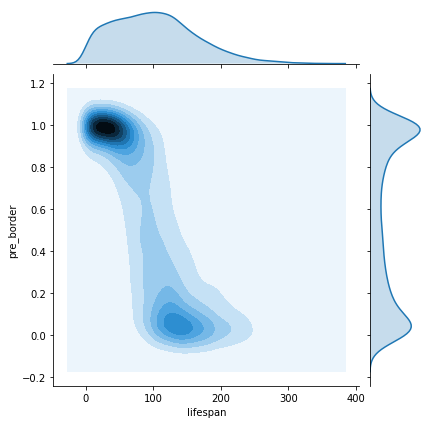

In [19]:
sns.jointplot(x="lifespan", y="pre_border", kind="kde", data=oof);

まあまあいい感じに見える？

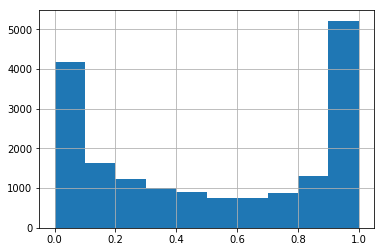

In [20]:
oof['pre_border'].hist()

=================  target < 100 のみ学習 ===============

In [21]:
df_train_end = pd.concat([df_train, target['lifespan']], axis=1)
df_train_end = df_train_end[df_train_end['lifespan'] < 100]
target_end = target[target['lifespan'] < 100]
del df_train_end['lifespan']

In [22]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.050,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [23]:
predictions = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train_end[df_train_end['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_fr = target_end[target_end['Flight Regime'] == fr][['lifespan', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_fr[(~(target_fr['EngineID'].isin(val_ID))) &
                                               (target_fr['EngineIndex'].isin(train_idx))]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_fr[target_fr['EngineID'].isin(val_ID) &
                                               target_fr['EngineIndex'].isin(test_lastidx)]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train[(df_train['Flight Regime'] == fr)&
                                      (df_train['EngineID'].isin(val_ID)) & 
                                      (df_train['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_end'] = val_pre
        
        predictions[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.32033	valid_1's l1: 9.01817
[200]	training's l1: 6.02253	valid_1's l1: 9.02538
[300]	training's l1: 5.2833	valid_1's l1: 9.17613
Early stopping, best iteration is:
[133]	training's l1: 6.75976	valid_1's l1: 8.92392
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.26526	valid_1's l1: 9.13987
[200]	training's l1: 5.99365	valid_1's l1: 8.98652
[300]	training's l1: 5.27691	valid_1's l1: 9.02368
Early stopping, best iteration is:
[123]	training's l1: 6.8556	valid_1's l1: 8.92475
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.32313	valid_1's l1: 9.0469
[200]	training's l1: 6.04869	valid_1's l1: 8.68816
[300]	training's l1: 5.31592	valid_1's l1: 8.69975
Early stopping, best iteration is:
[163]	training's l1: 6.41999	valid_1's l1: 8.62995
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.36479	valid_1's l1: 9.13468
[200]	training's l1: 6.06322	valid_1's l1: 8.57008
[300]	training's l1: 5.27962	valid_1's l1: 8.60335
[400]	training's l1: 4.7024	valid_1's l1: 8.65921
Early stopping, best iteration is:
[225]	training's l1: 5.83753	valid_1's l1: 8.5317
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.148	valid_1's l1: 11.2797
[200]	training's l1: 5.93246	valid_1's l1: 10.9836
[300]	training's l1: 5.20543	valid_1's l1: 10.9161
[400]	training's l1: 4.68365	valid_1's l1: 10.9323
Early stopping, best iteration is:
[253]	training's l1: 5.51462	valid_1's l1: 10.8735
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.31058	valid_1's l1: 9.66969
[200]	training's l1: 6.0707	valid_1's l1: 9.36689
[300]	training's l1: 5.3318	valid_1's l1: 9.21909
[400]	training's l1: 4.80928	valid_1's l1: 9.19062
[500]	training's l1: 4.37229	valid_1's l1: 9.23572
[600]	training's l1: 4.00249	valid_1's l1: 9.31833
Early stopping, best iteration is:
[403]	training's l1: 4.79629	valid_1's l1: 9.17537
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.2838	valid_1's l1: 8.90476
[200]	training's l1: 6.00129	valid_1's l1: 8.7194
[300]	training's l1: 5.26599	valid_1's l1: 8.78491
Early stopping, best iteration is:
[160]	training's l1: 6.40815	valid_1's l1: 8.60236
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.23126	valid_1's l1: 9.07883
[200]	training's l1: 5.96527	valid_1's l1: 9.25305
[300]	training's l1: 5.25599	valid_1's l1: 9.28536
Early stopping, best iteration is:
[114]	training's l1: 6.97491	valid_1's l1: 9.0127
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.18692	valid_1's l1: 9.56273
[200]	training's l1: 5.91657	valid_1's l1: 9.69862
Early stopping, best iteration is:
[98]	training's l1: 7.22617	valid_1's l1: 9.51855
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.29183	valid_1's l1: 8.57343
[200]	training's l1: 5.98537	valid_1's l1: 8.42834
[300]	training's l1: 5.26665	valid_1's l1: 8.40432
[400]	training's l1: 4.72871	valid_1's l1: 8.44677
Early stopping, best iteration is:
[283]	training's l1: 5.37995	valid_1's l1: 8.36062


 17%|██████████████                                                                      | 1/6 [01:03<05:15, 63.06s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.69166	valid_1's l1: 9.29588
[200]	training's l1: 6.24558	valid_1's l1: 9.06691
[300]	training's l1: 5.40953	valid_1's l1: 9.06897
[400]	training's l1: 4.81709	valid_1's l1: 8.9955
[500]	training's l1: 4.34266	valid_1's l1: 8.96939
[600]	training's l1: 3.95384	valid_1's l1: 8.98995
Early stopping, best iteration is:
[421]	training's l1: 4.71058	valid_1's l1: 8.94641
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.64201	valid_1's l1: 9.90674
[200]	training's l1: 6.25684	valid_1's l1: 9.68573
[300]	training's l1: 5.46519	valid_1's l1: 9.45808
[400]	training's l1: 4.87103	valid_1's l1: 9.35921
[500]	training's l1: 4.41145	valid_1's l1: 9.33239
[600]	training's l1: 4.02326	valid_1's l1: 9.33575
[700]	training's l1: 3.69834	valid_1's l1: 9.28943
Early stopping, best iteration is:
[539]	training's l1: 4.25439	valid_1's l1: 9.26318
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.77461	valid_1's l1: 8.91317
[200]	training's l1: 6.2925	valid_1's l1: 8.5333
[300]	training's l1: 5.43573	valid_1's l1: 8.58247
Early stopping, best iteration is:
[180]	training's l1: 6.50075	valid_1's l1: 8.49772
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.75726	valid_1's l1: 8.98854
[200]	training's l1: 6.35343	valid_1's l1: 8.43127
[300]	training's l1: 5.52462	valid_1's l1: 8.16594
[400]	training's l1: 4.92815	valid_1's l1: 8.01757
[500]	training's l1: 4.4662	valid_1's l1: 7.90153
[600]	training's l1: 4.084	valid_1's l1: 7.86678
[700]	training's l1: 3.75713	valid_1's l1: 7.91224
[800]	training's l1: 3.46802	valid_1's l1: 7.88622
[900]	training's l1: 3.22579	valid_1's l1: 7.85687
[1000]	training's l1: 3.00674	valid_1's l1: 7.81645
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 3.00674	valid_1's l1: 7.81645
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.4689	valid_1's l1: 11.3502
[200]	training's l1: 6.12061	valid_1's l1: 11.0925
[300]	training's l1: 5.3486	valid_1's l1: 11.1585
Early stopping, best iteration is:
[124]	training's l1: 7.03893	valid_1's l1: 11.0412
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.59326	valid_1's l1: 10.6977
[200]	training's l1: 6.15528	valid_1's l1: 10.565
[300]	training's l1: 5.31805	valid_1's l1: 10.8309
Early stopping, best iteration is:
[156]	training's l1: 6.6646	valid_1's l1: 10.4059
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.63943	valid_1's l1: 10.4683
[200]	training's l1: 6.24705	valid_1's l1: 9.92717
[300]	training's l1: 5.43172	valid_1's l1: 9.82709
[400]	training's l1: 4.84499	valid_1's l1: 9.87662
[500]	training's l1: 4.37333	valid_1's l1: 9.87517
Early stopping, best iteration is:
[331]	training's l1: 5.23929	valid_1's l1: 9.8107
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.71488	valid_1's l1: 8.33438
[200]	training's l1: 6.33496	valid_1's l1: 8.0354
[300]	training's l1: 5.49425	valid_1's l1: 8.08212
[400]	training's l1: 4.88606	valid_1's l1: 8.08509
Early stopping, best iteration is:
[225]	training's l1: 6.10006	valid_1's l1: 7.96622
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.65195	valid_1's l1: 9.79603
[200]	training's l1: 6.1635	valid_1's l1: 9.71461
[300]	training's l1: 5.33845	valid_1's l1: 9.68147
[400]	training's l1: 4.74493	valid_1's l1: 9.85611
Early stopping, best iteration is:
[298]	training's l1: 5.3532	valid_1's l1: 9.66413
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.66003	valid_1's l1: 9.09804
[200]	training's l1: 6.28159	valid_1's l1: 8.7468
[300]	training's l1: 5.44646	valid_1's l1: 8.78403
Early stopping, best iteration is:
[162]	training's l1: 6.68295	valid_1's l1: 8.698


 33%|████████████████████████████                                                        | 2/6 [02:13<04:20, 65.15s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.95711	valid_1's l1: 8.34799
[200]	training's l1: 6.49182	valid_1's l1: 8.1641
[300]	training's l1: 5.65959	valid_1's l1: 8.20453
Early stopping, best iteration is:
[194]	training's l1: 6.55481	valid_1's l1: 8.12293
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.84994	valid_1's l1: 9.80028
[200]	training's l1: 6.42956	valid_1's l1: 9.86747
Early stopping, best iteration is:
[94]	training's l1: 7.9834	valid_1's l1: 9.73351
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.94225	valid_1's l1: 10.2762
[200]	training's l1: 6.5568	valid_1's l1: 9.79772
[300]	training's l1: 5.70815	valid_1's l1: 9.72475
[400]	training's l1: 5.08905	valid_1's l1: 9.5838
[500]	training's l1: 4.59069	valid_1's l1: 9.65693
[600]	training's l1: 4.18622	valid_1's l1: 9.68621
Early stopping, best iteration is:
[446]	training's l1: 4.84269	valid_1's l1: 9.57078
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.92355	valid_1's l1: 9.90635
[200]	training's l1: 6.49674	valid_1's l1: 9.62666
[300]	training's l1: 5.66332	valid_1's l1: 9.53249
[400]	training's l1: 5.04825	valid_1's l1: 9.56739
[500]	training's l1: 4.56604	valid_1's l1: 9.64321
Early stopping, best iteration is:
[362]	training's l1: 5.26038	valid_1's l1: 9.49018
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.82047	valid_1's l1: 10.4835
[200]	training's l1: 6.40097	valid_1's l1: 10.2247
[300]	training's l1: 5.60075	valid_1's l1: 10.2265
[400]	training's l1: 4.98557	valid_1's l1: 10.15
Early stopping, best iteration is:
[237]	training's l1: 6.08829	valid_1's l1: 10.124
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.77898	valid_1's l1: 11.4266
[200]	training's l1: 6.37089	valid_1's l1: 11.0145
[300]	training's l1: 5.56324	valid_1's l1: 10.856
[400]	training's l1: 4.94056	valid_1's l1: 10.8803
[500]	training's l1: 4.45658	valid_1's l1: 11.0366
Early stopping, best iteration is:
[345]	training's l1: 5.26709	valid_1's l1: 10.8121
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.9084	valid_1's l1: 9.91427
[200]	training's l1: 6.42337	valid_1's l1: 9.95323
[300]	training's l1: 5.59484	valid_1's l1: 10.0455
Early stopping, best iteration is:
[101]	training's l1: 7.88251	valid_1's l1: 9.89312
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.84744	valid_1's l1: 10.3861
[200]	training's l1: 6.42187	valid_1's l1: 10.1269
[300]	training's l1: 5.59325	valid_1's l1: 10.0361
[400]	training's l1: 4.99683	valid_1's l1: 10.19
Early stopping, best iteration is:
[239]	training's l1: 6.06707	valid_1's l1: 10.0222
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.83917	valid_1's l1: 8.94433
[200]	training's l1: 6.44136	valid_1's l1: 9.01337
Early stopping, best iteration is:
[98]	training's l1: 7.88843	valid_1's l1: 8.93449
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.86675	valid_1's l1: 9.8633
[200]	training's l1: 6.47394	valid_1's l1: 9.46069
[300]	training's l1: 5.65855	valid_1's l1: 9.41794
[400]	training's l1: 5.0117	valid_1's l1: 9.43933
[500]	training's l1: 4.51499	valid_1's l1: 9.49112
Early stopping, best iteration is:
[324]	training's l1: 5.48776	valid_1's l1: 9.40368


 50%|██████████████████████████████████████████                                          | 3/6 [03:03<03:02, 60.75s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.28669	valid_1's l1: 9.42835
[200]	training's l1: 6.77724	valid_1's l1: 9.01199
[300]	training's l1: 5.83494	valid_1's l1: 8.90009
[400]	training's l1: 5.15568	valid_1's l1: 8.83978
[500]	training's l1: 4.62212	valid_1's l1: 8.81343
[600]	training's l1: 4.19179	valid_1's l1: 8.85141
Early stopping, best iteration is:
[483]	training's l1: 4.70586	valid_1's l1: 8.75802
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.30402	valid_1's l1: 10.2984
[200]	training's l1: 6.75739	valid_1's l1: 10.1344
[300]	training's l1: 5.85935	valid_1's l1: 10.2821
Early stopping, best iteration is:
[148]	training's l1: 7.39511	valid_1's l1: 9.92663
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.24137	valid_1's l1: 9.84652
[200]	training's l1: 6.71193	valid_1's l1: 9.28789
[300]	training's l1: 5.79187	valid_1's l1: 9.34309
Early stopping, best iteration is:
[184]	training's l1: 6.88979	valid_1's l1: 9.21751
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.3641	valid_1's l1: 11.0469
[200]	training's l1: 6.78124	valid_1's l1: 10.8029
[300]	training's l1: 5.88831	valid_1's l1: 10.8783
Early stopping, best iteration is:
[187]	training's l1: 6.93298	valid_1's l1: 10.7526
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.13001	valid_1's l1: 11.3763
[200]	training's l1: 6.53628	valid_1's l1: 11.2511
[300]	training's l1: 5.64677	valid_1's l1: 11.4612
Early stopping, best iteration is:
[132]	training's l1: 7.47714	valid_1's l1: 11.1861
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.22882	valid_1's l1: 10.9685
[200]	training's l1: 6.73654	valid_1's l1: 10.4818
[300]	training's l1: 5.88026	valid_1's l1: 10.4284
[400]	training's l1: 5.21412	valid_1's l1: 10.3337
[500]	training's l1: 4.6673	valid_1's l1: 10.3068
[600]	training's l1: 4.22926	valid_1's l1: 10.3952
Early stopping, best iteration is:
[463]	training's l1: 4.85645	valid_1's l1: 10.2405
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.22999	valid_1's l1: 10.5417
[200]	training's l1: 6.67912	valid_1's l1: 10.4381
[300]	training's l1: 5.77878	valid_1's l1: 10.4023
[400]	training's l1: 5.12647	valid_1's l1: 10.5026
Early stopping, best iteration is:
[242]	training's l1: 6.25481	valid_1's l1: 10.3613
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.33583	valid_1's l1: 10.1628
[200]	training's l1: 6.74351	valid_1's l1: 9.9559
[300]	training's l1: 5.82576	valid_1's l1: 10.0672
Early stopping, best iteration is:
[136]	training's l1: 7.61544	valid_1's l1: 9.82514
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.27058	valid_1's l1: 9.66872
[200]	training's l1: 6.6929	valid_1's l1: 9.85618
[300]	training's l1: 5.78138	valid_1's l1: 9.95954
Early stopping, best iteration is:
[117]	training's l1: 7.88972	valid_1's l1: 9.63811
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.34634	valid_1's l1: 10.1567
[200]	training's l1: 6.72498	valid_1's l1: 10.1218
[300]	training's l1: 5.78465	valid_1's l1: 10.3606
Early stopping, best iteration is:
[148]	training's l1: 7.4156	valid_1's l1: 9.92098


 67%|████████████████████████████████████████████████████████                            | 4/6 [03:47<01:51, 55.81s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.31883	valid_1's l1: 10.5697
[200]	training's l1: 6.79503	valid_1's l1: 10.8651
[300]	training's l1: 5.879	valid_1's l1: 10.9911
Early stopping, best iteration is:
[102]	training's l1: 8.27632	valid_1's l1: 10.5279
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.2802	valid_1's l1: 10.4297
[200]	training's l1: 6.80537	valid_1's l1: 10.23
[300]	training's l1: 5.90385	valid_1's l1: 10.2061
[400]	training's l1: 5.21644	valid_1's l1: 10.1388
[500]	training's l1: 4.67604	valid_1's l1: 10.1773
[600]	training's l1: 4.26435	valid_1's l1: 10.1526
Early stopping, best iteration is:
[421]	training's l1: 5.08612	valid_1's l1: 10.1221
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.28918	valid_1's l1: 10.9718
[200]	training's l1: 6.80789	valid_1's l1: 11.0678
[300]	training's l1: 5.85746	valid_1's l1: 11.1612
Early stopping, best iteration is:
[152]	training's l1: 7.41024	valid_1's l1: 10.8713
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.3526	valid_1's l1: 9.30981
[200]	training's l1: 6.81827	valid_1's l1: 9.2131
[300]	training's l1: 5.9	valid_1's l1: 9.28775
Early stopping, best iteration is:
[118]	training's l1: 7.96636	valid_1's l1: 9.17587
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.14746	valid_1's l1: 12.2984
[200]	training's l1: 6.67285	valid_1's l1: 12.2723
[300]	training's l1: 5.75844	valid_1's l1: 12.26
Early stopping, best iteration is:
[171]	training's l1: 7.01051	valid_1's l1: 12.1989
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.16362	valid_1's l1: 11.1214
[200]	training's l1: 6.67568	valid_1's l1: 10.8278
[300]	training's l1: 5.78536	valid_1's l1: 10.6526
[400]	training's l1: 5.11378	valid_1's l1: 10.5807
[500]	training's l1: 4.59851	valid_1's l1: 10.6024
[600]	training's l1: 4.15826	valid_1's l1: 10.5076
[700]	training's l1: 3.80961	valid_1's l1: 10.5739
Early stopping, best iteration is:
[595]	training's l1: 4.18002	valid_1's l1: 10.4972
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.29163	valid_1's l1: 9.95989
[200]	training's l1: 6.75852	valid_1's l1: 9.51187
[300]	training's l1: 5.83488	valid_1's l1: 9.50287
[400]	training's l1: 5.13903	valid_1's l1: 9.45295
[500]	training's l1: 4.6092	valid_1's l1: 9.49509
[600]	training's l1: 4.18277	valid_1's l1: 9.47098
[700]	training's l1: 3.82918	valid_1's l1: 9.51026
Early stopping, best iteration is:
[549]	training's l1: 4.39123	valid_1's l1: 9.39338
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.22081	valid_1's l1: 11.3311
[200]	training's l1: 6.66066	valid_1's l1: 11.3467
[300]	training's l1: 5.74134	valid_1's l1: 11.2637
Early stopping, best iteration is:
[118]	training's l1: 7.83751	valid_1's l1: 11.1967
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.29083	valid_1's l1: 11.8103
[200]	training's l1: 6.74421	valid_1's l1: 11.7335
[300]	training's l1: 5.82095	valid_1's l1: 11.6941
[400]	training's l1: 5.14567	valid_1's l1: 11.7108
[500]	training's l1: 4.59514	valid_1's l1: 11.8377
Early stopping, best iteration is:
[324]	training's l1: 5.64008	valid_1's l1: 11.6484
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 8.36634	valid_1's l1: 9.60569
[200]	training's l1: 6.86627	valid_1's l1: 9.36153
[300]	training's l1: 5.9224	valid_1's l1: 9.55153
Early stopping, best iteration is:
[179]	training's l1: 7.10519	valid_1's l1: 9.29548


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [04:59<01:00, 60.43s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 6.98824	valid_1's l1: 8.83922
[200]	training's l1: 5.52936	valid_1's l1: 8.8335
[300]	training's l1: 4.69651	valid_1's l1: 8.75883
[400]	training's l1: 4.13242	valid_1's l1: 8.8458
Early stopping, best iteration is:
[274]	training's l1: 4.88704	valid_1's l1: 8.71728
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 6.9924	valid_1's l1: 9.70854
[200]	training's l1: 5.59148	valid_1's l1: 9.22949
[300]	training's l1: 4.71681	valid_1's l1: 9.12555
[400]	training's l1: 4.12226	valid_1's l1: 9.14526
Early stopping, best iteration is:
[269]	training's l1: 4.96655	valid_1's l1: 9.0986
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.0483	valid_1's l1: 8.97292
[200]	training's l1: 5.59011	valid_1's l1: 8.57634
[300]	training's l1: 4.7817	valid_1's l1: 8.50122
[400]	training's l1: 4.15844	valid_1's l1: 8.4793
[500]	training's l1: 3.69429	valid_1's l1: 8.44744
Early stopping, best iteration is:
[360]	training's l1: 4.38718	valid_1's l1: 8.41623
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 6.97143	valid_1's l1: 9.7087
[200]	training's l1: 5.53261	valid_1's l1: 9.49757
[300]	training's l1: 4.66136	valid_1's l1: 9.59371
Early stopping, best iteration is:
[157]	training's l1: 6.06359	valid_1's l1: 9.44089
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 6.91118	valid_1's l1: 10.0509
[200]	training's l1: 5.48722	valid_1's l1: 9.94029
[300]	training's l1: 4.6524	valid_1's l1: 10.0378
Early stopping, best iteration is:
[158]	training's l1: 5.96113	valid_1's l1: 9.90932
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 6.91393	valid_1's l1: 10.4849
[200]	training's l1: 5.49713	valid_1's l1: 10.247
[300]	training's l1: 4.66699	valid_1's l1: 10.2262
[400]	training's l1: 4.09088	valid_1's l1: 10.314
Early stopping, best iteration is:
[240]	training's l1: 5.13603	valid_1's l1: 10.1694
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.03704	valid_1's l1: 10.1687
[200]	training's l1: 5.59472	valid_1's l1: 10.2726
[300]	training's l1: 4.7638	valid_1's l1: 10.401
Early stopping, best iteration is:
[107]	training's l1: 6.8724	valid_1's l1: 10.1249
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.02748	valid_1's l1: 9.82391
[200]	training's l1: 5.55875	valid_1's l1: 9.45281
[300]	training's l1: 4.696	valid_1's l1: 9.53652
[400]	training's l1: 4.12199	valid_1's l1: 9.59377
Early stopping, best iteration is:
[203]	training's l1: 5.52971	valid_1's l1: 9.43708
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.01558	valid_1's l1: 10.098
[200]	training's l1: 5.5403	valid_1's l1: 10.0176
[300]	training's l1: 4.69951	valid_1's l1: 10.0496
Early stopping, best iteration is:
[169]	training's l1: 5.88791	valid_1's l1: 9.95477
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 7.02261	valid_1's l1: 10.5266
[200]	training's l1: 5.60133	valid_1's l1: 10.4429
[300]	training's l1: 4.78171	valid_1's l1: 10.6214
Early stopping, best iteration is:
[149]	training's l1: 6.19897	valid_1's l1: 10.3799


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:59<00:00, 60.52s/it]


In [87]:
test_pre_end = predictions

In [89]:
oof_end = oof[oof['lifespan'] < 100]
mean_absolute_error(oof_end['pre_end'], oof_end['lifespan'])

8.872598597993655

=========== lifespan >= 100 ================

In [90]:
df_train_start = pd.concat([df_train, target['lifespan']], axis=1)
df_train_start = df_train_start[df_train_start['lifespan'] >= 100]
target_start = target[target['lifespan'] >= 100]
del df_train_start['lifespan']

In [136]:
predictions = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train_start[df_train_start['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_fr = target_start[target_start['Flight Regime'] == fr][['lifespan', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_fr[(~(target_fr['EngineID'].isin(val_ID))) &
                                               (target_fr['EngineIndex'].isin(train_idx))]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_fr[target_fr['EngineID'].isin(val_ID) &
                                               target_fr['EngineIndex'].isin(test_lastidx)]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train[(df_train['Flight Regime'] == fr)&
                                      (df_train['EngineID'].isin(val_ID)) & 
                                      (df_train['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_start'] = val_pre
        
        predictions[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9692	valid_1's l1: 31.1384
[200]	training's l1: 18.7179	valid_1's l1: 31.2502
Early stopping, best iteration is:
[40]	training's l1: 27.1491	valid_1's l1: 29.7723
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.0721	valid_1's l1: 31.2935
[200]	training's l1: 18.8076	valid_1's l1: 31.741
Early stopping, best iteration is:
[54]	training's l1: 26.0011	valid_1's l1: 30.5784
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.8458	valid_1's l1: 32.0217
[200]	training's l1: 18.7959	valid_1's l1: 32.6066
Early stopping, best iteration is:
[27]	training's l1: 28.5084	valid_1's l1: 31.2238
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.0724	valid_1's l1: 32.7942
[200]	training's l1: 18.8662	valid_1's l1: 32.5214
[300]	training's l1: 16.1167	valid_1's l1: 32.6043
Early stopping, best iteration is:
[158]	training's l1: 20.3455	valid_1's l1: 32.0224
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.4482	valid_1's l1: 34.9368
[200]	training's l1: 18.2021	valid_1's l1: 34.9104
Early stopping, best iteration is:
[24]	training's l1: 28.9469	valid_1's l1: 33.6138
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.2081	valid_1's l1: 28.7696
[200]	training's l1: 19.0294	valid_1's l1: 28.8485
Early stopping, best iteration is:
[52]	training's l1: 26.4207	valid_1's l1: 28.2377
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.1436	valid_1's l1: 31.6262
[200]	training's l1: 18.984	valid_1's l1: 32.1978
Early stopping, best iteration is:
[80]	training's l1: 24.3372	valid_1's l1: 30.9278
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.3759	valid_1's l1: 29.9432
[200]	training's l1: 19.1133	valid_1's l1: 29.7654
Early stopping, best iteration is:
[22]	training's l1: 29.7146	valid_1's l1: 29.1417
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.4423	valid_1's l1: 28.5912
[200]	training's l1: 19.2738	valid_1's l1: 28.8228
Early stopping, best iteration is:
[64]	training's l1: 25.638	valid_1's l1: 28.0055
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.3112	valid_1's l1: 31.5426
[200]	training's l1: 19.1352	valid_1's l1: 32.2079
Early stopping, best iteration is:
[24]	training's l1: 29.4674	valid_1's l1: 29.7491



 17%|██████████████                                                                      | 1/6 [00:32<02:40, 32.16s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.1652	valid_1's l1: 36.0041
[200]	training's l1: 18.8569	valid_1's l1: 36.6654
Early stopping, best iteration is:
[96]	training's l1: 23.3946	valid_1's l1: 35.9002
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.2663	valid_1's l1: 33.3651
[200]	training's l1: 18.8308	valid_1's l1: 33.6807
Early stopping, best iteration is:
[42]	training's l1: 27.321	valid_1's l1: 32.9752
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9276	valid_1's l1: 37.9297
[200]	training's l1: 18.8084	valid_1's l1: 39.5866
Early stopping, best iteration is:
[17]	training's l1: 30.1381	valid_1's l1: 36.6274
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.3501	valid_1's l1: 32.5163
[200]	training's l1: 18.8798	valid_1's l1: 32.7139
Early stopping, best iteration is:
[90]	training's l1: 23.9404	valid_1's l1: 32.1906
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.2272	valid_1's l1: 38.1312
[200]	training's l1: 19.0513	valid_1's l1: 38.7755
Early stopping, best iteration is:
[25]	training's l1: 29.437	valid_1's l1: 36.2708
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9166	valid_1's l1: 33.8361
[200]	training's l1: 18.4778	valid_1's l1: 35.3356
Early stopping, best iteration is:
[33]	training's l1: 28.2924	valid_1's l1: 32.2372
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.36	valid_1's l1: 32.0915
[200]	training's l1: 19.0459	valid_1's l1: 32.1089
Early stopping, best iteration is:
[32]	training's l1: 28.6958	valid_1's l1: 30.5616
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.7764	valid_1's l1: 29.7072
[200]	training's l1: 19.4748	valid_1's l1: 29.6067
Early stopping, best iteration is:
[54]	training's l1: 26.7535	valid_1's l1: 29.3529
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.7063	valid_1's l1: 29.235
[200]	training's l1: 19.2069	valid_1's l1: 29.7692
Early stopping, best iteration is:
[49]	training's l1: 27.3459	valid_1's l1: 28.689
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.9239	valid_1's l1: 29.3954
[200]	training's l1: 19.5465	valid_1's l1: 29.9321
Early stopping, best iteration is:
[66]	training's l1: 26.0932	valid_1's l1: 29.1604



 33%|████████████████████████████                                                        | 2/6 [01:07<02:12, 33.24s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.2508	valid_1's l1: 36.886
[200]	training's l1: 17.9158	valid_1's l1: 37.9755
Early stopping, best iteration is:
[25]	training's l1: 29.2106	valid_1's l1: 34.4428
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9257	valid_1's l1: 35.4494
[200]	training's l1: 18.4977	valid_1's l1: 34.2789
[300]	training's l1: 15.6261	valid_1's l1: 34.2901
Early stopping, best iteration is:
[178]	training's l1: 19.2653	valid_1's l1: 34.1406
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9181	valid_1's l1: 30.5266
[200]	training's l1: 18.399	valid_1's l1: 30.4267
[300]	training's l1: 15.5486	valid_1's l1: 30.5771
[400]	training's l1: 13.5204	valid_1's l1: 31.0562
Early stopping, best iteration is:
[257]	training's l1: 16.6507	valid_1's l1: 30.2286
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.6269	valid_1's l1: 33.1644
[200]	training's l1: 18.2238	valid_1's l1: 33.5226
Early stopping, best iteration is:
[57]	training's l1: 25.79	valid_1's l1: 32.5413
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.0862	valid_1's l1: 33.6492
[200]	training's l1: 17.7961	valid_1's l1: 34.8545
Early stopping, best iteration is:
[18]	training's l1: 30.4553	valid_1's l1: 32.1434
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.7202	valid_1's l1: 30.8737
[200]	training's l1: 18.3996	valid_1's l1: 31.0229
[300]	training's l1: 15.6068	valid_1's l1: 31.3513
Early stopping, best iteration is:
[136]	training's l1: 20.8359	valid_1's l1: 30.4956
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.0679	valid_1's l1: 29.9004
[200]	training's l1: 18.4771	valid_1's l1: 29.5476
[300]	training's l1: 15.6757	valid_1's l1: 29.7484
[400]	training's l1: 13.7323	valid_1's l1: 29.7114
[500]	training's l1: 12.1157	valid_1's l1: 29.8356
Early stopping, best iteration is:
[340]	training's l1: 14.8398	valid_1's l1: 29.3153
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.4129	valid_1's l1: 24.7193
[200]	training's l1: 18.7929	valid_1's l1: 24.2002
[300]	training's l1: 15.9227	valid_1's l1: 24.4604
Early stopping, best iteration is:
[171]	training's l1: 19.7926	valid_1's l1: 24.1903
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.1781	valid_1's l1: 27.23
[200]	training's l1: 18.6604	valid_1's l1: 28.0789
Early stopping, best iteration is:
[85]	training's l1: 24.0651	valid_1's l1: 26.8953
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.1065	valid_1's l1: 26.9985
[200]	training's l1: 18.8361	valid_1's l1: 27.604
Early stopping, best iteration is:
[39]	training's l1: 28.0582	valid_1's l1: 25.8547



 50%|██████████████████████████████████████████                                          | 3/6 [01:48<01:45, 35.31s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 21.7903	valid_1's l1: 36.3955
[200]	training's l1: 17.6455	valid_1's l1: 37.1081
Early stopping, best iteration is:
[62]	training's l1: 24.215	valid_1's l1: 36.104
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.456	valid_1's l1: 30.8521
[200]	training's l1: 18.2337	valid_1's l1: 31.7517
Early stopping, best iteration is:
[72]	training's l1: 24.1656	valid_1's l1: 30.437
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.1637	valid_1's l1: 33.3189
[200]	training's l1: 18.088	valid_1's l1: 34.8614
Early stopping, best iteration is:
[61]	training's l1: 24.6244	valid_1's l1: 32.966
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 21.951	valid_1's l1: 32.5783
[200]	training's l1: 17.9184	valid_1's l1: 32.4896
[300]	training's l1: 15.3104	valid_1's l1: 32.8434
Early stopping, best iteration is:
[160]	training's l1: 19.3031	valid_1's l1: 32.238
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 21.8457	valid_1's l1: 31.3872
[200]	training's l1: 17.8836	valid_1's l1: 31.8528
Early stopping, best iteration is:
[25]	training's l1: 28.1719	valid_1's l1: 30.5068
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 21.7921	valid_1's l1: 31.2947
[200]	training's l1: 17.7216	valid_1's l1: 32.4995
[300]	training's l1: 14.9285	valid_1's l1: 32.8163
Early stopping, best iteration is:
[104]	training's l1: 21.5744	valid_1's l1: 31.18
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.565	valid_1's l1: 28.7167
[200]	training's l1: 18.5617	valid_1's l1: 29.6775
Early stopping, best iteration is:
[75]	training's l1: 24.0977	valid_1's l1: 27.7753
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.4354	valid_1's l1: 28.3185
[200]	training's l1: 18.1951	valid_1's l1: 28.927
Early stopping, best iteration is:
[84]	training's l1: 23.3424	valid_1's l1: 28.2309
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.5234	valid_1's l1: 25.2744
[200]	training's l1: 18.4184	valid_1's l1: 25.2708
[300]	training's l1: 15.6593	valid_1's l1: 25.3982
Early stopping, best iteration is:
[183]	training's l1: 18.9999	valid_1's l1: 25.0708
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.1838	valid_1's l1: 26.3
[200]	training's l1: 18.0786	valid_1's l1: 26.065
Early stopping, best iteration is:
[83]	training's l1: 23.2243	valid_1's l1: 25.8467



 67%|████████████████████████████████████████████████████████                            | 4/6 [02:22<01:10, 35.18s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.6108	valid_1's l1: 35.0039
[200]	training's l1: 18.2958	valid_1's l1: 34.6547
Early stopping, best iteration is:
[45]	training's l1: 26.4644	valid_1's l1: 34.2862
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.961	valid_1's l1: 36.8919
[200]	training's l1: 18.4093	valid_1's l1: 37.97
Early stopping, best iteration is:
[77]	training's l1: 24.4306	valid_1's l1: 36.4786
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.0077	valid_1's l1: 31.7281
[200]	training's l1: 18.4068	valid_1's l1: 32.5264
Early stopping, best iteration is:
[56]	training's l1: 25.941	valid_1's l1: 31.3046
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.098	valid_1's l1: 33.9405
[200]	training's l1: 18.6335	valid_1's l1: 33.5131
[300]	training's l1: 15.9459	valid_1's l1: 33.2568
[400]	training's l1: 13.9025	valid_1's l1: 33.1568
Early stopping, best iteration is:
[270]	training's l1: 16.6339	valid_1's l1: 33.0749
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9965	valid_1's l1: 29.6254
[200]	training's l1: 18.7059	valid_1's l1: 29.8689
Early stopping, best iteration is:
[21]	training's l1: 29.799	valid_1's l1: 28.6427
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.6321	valid_1's l1: 30.6909
[200]	training's l1: 18.2041	valid_1's l1: 31.1396
Early stopping, best iteration is:
[39]	training's l1: 27.1874	valid_1's l1: 30.3516
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.6787	valid_1's l1: 29.4818
[200]	training's l1: 18.43	valid_1's l1: 30.5702
Early stopping, best iteration is:
[18]	training's l1: 30.2718	valid_1's l1: 27.084
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.083	valid_1's l1: 27.7404
[200]	training's l1: 18.815	valid_1's l1: 27.597
Early stopping, best iteration is:
[28]	training's l1: 29.2655	valid_1's l1: 27.4396
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 22.9187	valid_1's l1: 29.8931
[200]	training's l1: 18.5085	valid_1's l1: 31.1469
Early stopping, best iteration is:
[32]	training's l1: 28.3549	valid_1's l1: 27.8546
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 23.0885	valid_1's l1: 33.9518
[200]	training's l1: 18.6562	valid_1's l1: 34.6651
Early stopping, best iteration is:
[25]	training's l1: 29.3198	valid_1's l1: 31.9713



 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:56<00:34, 34.74s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.0826	valid_1's l1: 31.8538
[200]	training's l1: 15.433	valid_1's l1: 32.3274
Early stopping, best iteration is:
[81]	training's l1: 21.2661	valid_1's l1: 31.5775
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.2807	valid_1's l1: 27.7322
[200]	training's l1: 15.4594	valid_1's l1: 27.8884
Early stopping, best iteration is:
[66]	training's l1: 22.7936	valid_1's l1: 27.4219
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 19.9467	valid_1's l1: 37.8714
[200]	training's l1: 15.3757	valid_1's l1: 38.5938
Early stopping, best iteration is:
[18]	training's l1: 29.0608	valid_1's l1: 35.3429
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.5048	valid_1's l1: 31.0435
[200]	training's l1: 15.9581	valid_1's l1: 30.7688
[300]	training's l1: 13.1844	valid_1's l1: 30.7947
[400]	training's l1: 11.2297	valid_1's l1: 30.4117
[500]	training's l1: 9.63995	valid_1's l1: 30.225
[600]	training's l1: 8.44415	valid_1's l1: 30.19
[700]	training's l1: 7.50752	valid_1's l1: 30.2307
[800]	training's l1: 6.77225	valid_1's l1: 30.2963
Early stopping, best iteration is:
[640]	training's l1: 8.03709	valid_1's l1: 30.0929
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 19.7059	valid_1's l1: 35.5682
[200]	training's l1: 15.0088	valid_1's l1: 35.6947
Early stopping, best iteration is:
[32]	training's l1: 26.3338	valid_1's l1: 34.9961
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.1407	valid_1's l1: 37.3305
[200]	training's l1: 15.6864	valid_1's l1: 38.1181
Early stopping, best iteration is:
[23]	training's l1: 28.1948	valid_1's l1: 36.4682
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.0769	valid_1's l1: 35.797
[200]	training's l1: 15.3182	valid_1's l1: 37.3654
Early stopping, best iteration is:
[30]	training's l1: 26.9912	valid_1's l1: 32.8805
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.5878	valid_1's l1: 26.7068
[200]	training's l1: 15.6567	valid_1's l1: 26.2773
[300]	training's l1: 12.8039	valid_1's l1: 26.972
Early stopping, best iteration is:
[144]	training's l1: 17.9655	valid_1's l1: 26.1655
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.799	valid_1's l1: 28.891
[200]	training's l1: 15.8145	valid_1's l1: 30.1032
Early stopping, best iteration is:
[40]	training's l1: 26.1113	valid_1's l1: 28.1573
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 20.3208	valid_1's l1: 28.931
[200]	training's l1: 15.7636	valid_1's l1: 28.5075
[300]	training's l1: 12.8609	valid_1's l1: 28.094
[400]	training's l1: 10.932	valid_1's l1: 28.3887
Early stopping, best iteration is:
[247]	training's l1: 14.1401	valid_1's l1: 28.0133



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:52<00:00, 41.10s/it]


In [138]:
test_pre_start = predictions

In [141]:
oof_start = oof[oof['lifespan'] >= 100]
mean_absolute_error(oof_start['lifespan'], oof_start['pre_start'])

30.883540717845364

In [101]:
oof['pre_target'] = oof['pre_start'] * (1 - oof['pre_border']) + oof['pre_end'] * oof['pre_border']

In [145]:
oof.to_csv('aaa.csv')

In [103]:
mean_absolute_error(oof['lifespan'], oof['pre_target'])

27.208670733829027

C:\Users\linda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


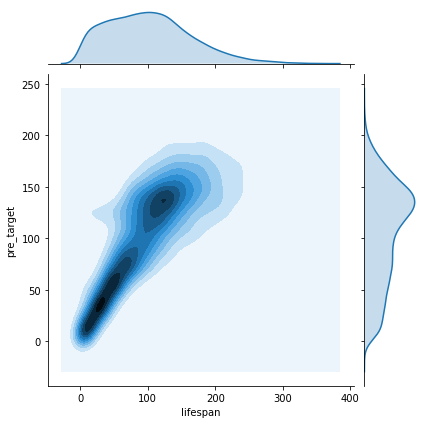

In [120]:
sns.jointplot(x="lifespan", y="pre_target", kind="kde", data=oof);

C:\Users\linda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


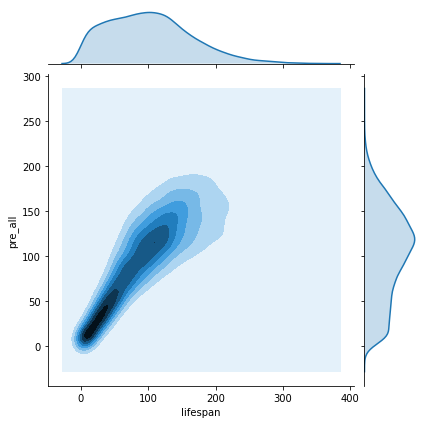

In [146]:
sns.jointplot(x="lifespan", y="pre_all", kind="kde", data=oof);

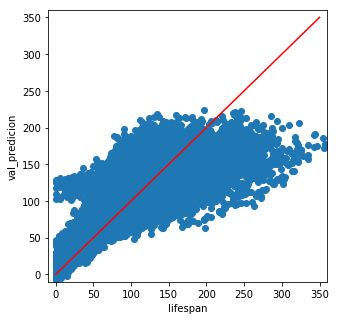

In [122]:
plt.figure(figsize=(5,5))
plt.plot(oof['lifespan'], oof['pre_target'], 'o')
plt.plot(np.array([0,350]), np.array([0,350]), c='red')
plt.xlabel('lifespan')
plt.ylabel('val_predicion')
plt.xlim([-10, 360])
plt.ylim([-10, 360]);

In [129]:
# submit
sub_df = pd.DataFrame({'EngineID': df_test['EngineID'],
                       'pre_border': test_pre_border,
                       'pre_start': test_pre_start,
                       'pre_end': test_pre_end})

sub_df['Predicted RUL'] = sub_df['pre_start'] * (1 - sub_df['pre_border']) + sub_df['pre_end'] * sub_df['pre_border']

# 必要なのは各エンジンの最後の行のみ
sub_df = sub_df[sub_df['EngineID'].astype('category').cat.codes.diff(-1) != 0]
sub_df['Predicted RUL'].to_csv('C0003_28_04_2019.csv', index=False)

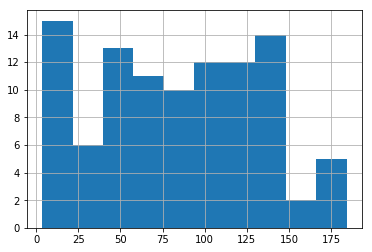

In [130]:
sub_df['Predicted RUL'].hist()